In [148]:
# 전제 : 시계열 데이터 처리
import pandas as pd
df = pd.read_csv("stock.csv")
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Volume    0
Close     0
dtype: int64

In [149]:
df.drop(["Date","Volume"], axis=1, inplace=True)

In [150]:
# stock : 
# 닫을 때 종가가 target이다 
# 주식을 며칠동안 볼건지 구간을 정해야 한다
# 한달이면 30일 
# 30일치 데이터를 가지고 내일 종가를 예측하겠다
# Open High Low 만 feature다 

In [151]:
# 딥러닝 RNN 으로 시계열 데이터 처리
# dataset, DataLoader import 하기
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
# stockDataset 데이터셋 클래스 생성
# feature : Open, High, Low
# target : Close

class stockDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
    def __len__(self):
        return len(self.data) - self.window_size
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.window_size, :-1]
        y = self.data[idx+self.window_size, -1]
        return x, y

In [152]:
trainDS = stockDataset(df.values, 30) # 한 달이라고 잡고, 데이터셋 생성 

In [153]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self): 
        super(RNN, self).__init__()
        self.hidden_size=8
        self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)
        self.fc = nn.Linear(240, 64)
        self.fc2 = nn.Linear(64, 1)
    def forward(self, x):
        h0 = torch.zeros(5, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = out.contiguous().view(out.size(0), -1)
        out = self.fc(out)
        out = self.fc2(out)
        return out
trainDL = DataLoader(trainDS, batch_size=8, shuffle=True, drop_last=True)

In [154]:
import numpy as np

model = RNN()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters())

r_squared_values = []
plot_predict=[]

for epoch in range(25):
    x_map = []
    y_map = []
    for i, (x, y) in enumerate(trainDL):
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
        
        output = model(x)
        loss = criterion(output, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        x_map.append(output)
        y_map.append(y)
        if epoch==24:
            plot_predict.append(output)
    
    # 결정계수 계산
    y_pred = np.concatenate([output.detach().numpy() for output in x_map])
    y_true = np.concatenate([label.detach().numpy() for label in y_map])
    mean_observed = np.mean(y_true)
    total_sum_of_squares = np.sum((y_true - mean_observed) ** 2)
    residual_sum_of_squares = np.sum((y_true - y_pred) ** 2)
    r_squared = 1 - (residual_sum_of_squares / total_sum_of_squares)
    r_squared_values.append(r_squared)
    
    print(epoch, loss.item(), "R-squared:", r_squared)


C:\Users\mathn\AppData\Local\Temp\ipykernel_25172\1432540165.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\mathn\AppData\Local\Temp\ipykernel_25172\1432540165.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)


0 10138.111328125 R-squared: -1.7396647930145264
1 6083.2041015625 R-squared: 0.0002893805503845215
2 407.2395935058594 R-squared: 0.7525377571582794
3 1171.3592529296875 R-squared: 0.9113877639174461
4 1723.83447265625 R-squared: 0.9005358219146729
5 977.924072265625 R-squared: 0.9124881625175476
6 316.19207763671875 R-squared: 0.9147269949316978
7 687.7102661132812 R-squared: 0.9230470135807991
8 988.164794921875 R-squared: 0.916072890162468
9 158.12303161621094 R-squared: 0.9202263355255127
10 1093.150390625 R-squared: 0.9240928068757057
11 656.4573974609375 R-squared: 0.9209267497062683
12 2218.837158203125 R-squared: 0.9225612729787827
13 435.36114501953125 R-squared: 0.9214554950594902
14 545.2470703125 R-squared: 0.91885856539011
15 599.6487426757812 R-squared: 0.9063160195946693
16 1254.773681640625 R-squared: 0.9242864102125168
17 732.047607421875 R-squared: 0.9243979156017303
18 607.5582275390625 R-squared: 0.927348792552948
19 555.93798828125 R-squared: 0.9201290532946587
20

In [155]:
flat_tensors = [tensor.detach().numpy().flatten() for tensor in plot_predict]
flat_data = [item for sublist in flat_tensors for item in sublist]

In [156]:
y=[0 for _ in range(31)]
y.extend(flat_data)

In [157]:
len(y)

967

In [158]:
len(df["Close"])

967

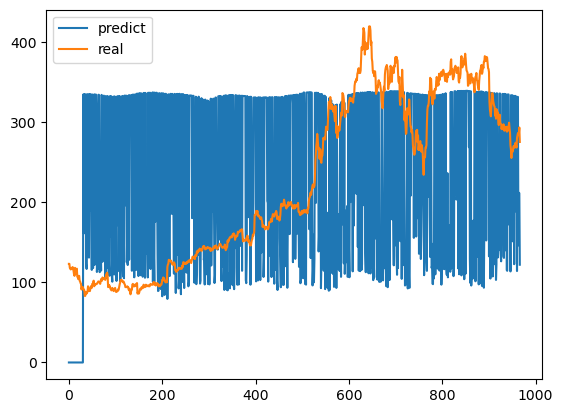

In [160]:
import matplotlib.pyplot as plt


plt.plot(y, label="predict")
plt.plot(df["Close"].values, label="real")
plt.legend()
plt.show()
# 쫀드기 완성 